In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import scipy.stats as st
import seaborn as sns


In [2]:

# Estimate secretion rate
fn_exometabolites = "../../data/e_coli/ecoli_exometabolites.csv"
fn_exometabolites_std = "../../data/e_coli/ecoli_exometabolites_std.csv"
exometabolites_folder = "../../data/e_coli/"
organism = "ecoli"

exometabolites_folder = Path(exometabolites_folder)
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [4]:
def get_leakage(data_folder, organism, time):
    exometabolites_folder = Path(data_folder)
    
    # Filenames
    fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
    fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
    fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
    
    # Read files as dataframes
    df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
    df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
    df_OD = pd.read_csv(fn_OD, index_col=0)
    
    met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]
    leakage_list = []
    leakage_uncertainty_list = []
    for met_abbrv in met_abbreviations:
        leakage, std = estimate_leakage_rate_for_met(time, met_abbrv, df_OD, df_exometabolites, df_exometabolites_std)
        leakage_list.append(leakage)
        leakage_uncertainty_list.append(std)
    #print(leakage_list)
    leakage_df = pd.DataFrame({"Metabolite": met_abbreviations, "Leakage (uM/h/OD)":leakage_list,"Leakage std": leakage_uncertainty_list})#, columns = ["Time", , "Leakage std"])
    return leakage_df
    
    

def estimate_leakage_rate_for_met(time, met_abbrv, df_OD, df_exometabolites, df_exometabolites_std):
    """
    Estimate leakage by dividing the change in concentration of two timepoints by the OD of the mean.
    Time = 6 or 7 seems to be mid-exponential phase
    """
    OD_mean = df_OD.loc[time, "OD mean"]
    OD_std = df_OD.loc[time, "OD std"]
    
    # met_conc
    met_conc_1 = df_exometabolites.loc[time-1, met_abbrv]
    met_conc_2 = df_exometabolites.loc[time+1, met_abbrv]
    met_conc_1_std = df_exometabolites_std.loc[time-1, met_abbrv]
    met_conc_2_std = df_exometabolites_std.loc[time+1, met_abbrv]
    
    # leakage rate
    delta_time = 2 # Divide by delta time = 2 hours
    leakage_per_h = (met_conc_2 - met_conc_1) / delta_time 
    leakage_rate_per_h_per_OD = leakage_per_h / OD_mean
    
    if leakage_per_h != 0:
        # Error propagation
        # Assume no covariance; https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae
        leakage_per_h_std = np.sqrt(met_conc_1_std**2 + met_conc_2_std**2)/delta_time
        #print(leakage_per_h_std, leakage_per_h, OD_std, OD_mean)
        rel_leakage_std = np.sqrt((leakage_per_h_std/leakage_per_h)**2+(OD_std/OD_mean)**2)
        leakage_std = rel_leakage_std*leakage_rate_per_h_per_OD
    else:
        leakage_std = 0
    return leakage_rate_per_h_per_OD, leakage_std
    
    
    #
    

In [5]:
leakage_df = get_leakage(exometabolites_folder, "ecoli", time = 7)
leakage_df.set_index("Metabolite", inplace=True)

In [6]:
leakage_df

,Leakage (uM/h/OD),Leakage std
Metabolite,,
G6P,0.440616,0.015430
F6P,0.718007,0.033832
FBP,0.359004,0.014058
DHAP,0.627496,0.065091
GA3P,0.186804,0.014218
23PG,0.254953,0.023705
PEP,0.069823,0.006347
R5P,0.092261,0.004086
RU5P+X5P,0.041445,0.003663


In [7]:
# Cost of synthesis

In [8]:
fn_cost = exometabolites_folder / "cost_of_aa_biosynthesis.csv"
df_cost = pd.read_csv(fn_cost, index_col=0, skiprows=3, header = [0,1])

In [9]:
leakage = []
total_cost_glucose = []
aa_list = []
leakage_error = []

for aa, row in df_cost.iterrows():
    try:
        leak = leakage_df.loc[aa.upper(), "Leakage (uM/h/OD)"]
    except KeyError:
        continue
    else:
        if leak > 0 and (leak > leakage_df.loc[aa.upper(), "Leakage std"]):
            # I dicard those metabolites where 0 is included in mean+- 1 std -> Doesn't work well when log-transformed errorbar plot
            leakage.append(leak)
            leakage_error.append(leakage_df.loc[aa.upper(), "Leakage std"])
            total_cost_glucose.append(row["Glucose"]["Total, ~P"])
            aa_list.append(aa)
leakage = np.array(leakage)
leakage_error = np.array(leakage_error)

In [66]:
import statsmodels.api as sm
# Fit
log10_leakage = np.log10(leakage)
log_leakage = np.log(leakage)
rho, pval = st.pearsonr(total_cost_glucose, log_leakage)

X = sm.add_constant(total_cost_glucose)
mod = sm.OLS(log_leakage, X)
res = mod.fit()
res.summary()


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     12.90
Date:                Thu, 23 Feb 2023   Prob (F-statistic):            0.00492
Time:                        14:00:57   Log-Likelihood:                -15.695
No. Observations:                  12   AIC:                             35.39
Df Residuals:                      10   BIC:                             36.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5375      0.588     -4.319      0.002      -3.847      -1.228
x1            -0.0660      0.018     -3.592      0.005      -0.107      -0.025
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.114
Skew:                           0.166   Prob(JB):                        0.944
Kurtosis:                       2.656   Cond. No.                         66.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
ci = res.conf_int()

intercept, slope = res.params
# From https://github.com/BMClab/BMC/blob/master/notebooks/CurveFitting.ipynb
ci = t * s_err * np.sqrt(    1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

In [120]:
log_leakage_error, aa_list

(array([0.51134159, 0.04773699, 0.22170666, 0.88699429, 0.02924831,
        0.10704605, 0.2388436 , 0.42363553, 0.35795103, 0.09052729,
        0.34622408, 0.51769062]),
 ['Ala',
  'Asp',
  'Phe',
  'His',
  'Leu',
  'Met',
  'Pro',
  'Arg',
  'Thr',
  'Val',
  'Trp',
  'Tyr'])

In [130]:
from scipy.optimize import curve_fit
fun = lambda x, a,b: a + b*x
# Estimate log_leakage std https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae
log_leakage_error = leakage_error / leakage

popt, pcov = curve_fit(fun, total_cost_glucose, log_leakage)
poptw, pcovw  = curve_fit(fun, total_cost_glucose, log_leakage, sigma=1/log_leakage_error, absolute_sigma=True) 
x_arr = np.linspace(np.min(total_cost_glucose), np.max(total_cost_glucose), 100)
y_fit = fun(x_arr, *popt)
y_fitw = fun(x_arr, *poptw)

In [131]:
resw = np.abs(log_leakage - fun(np.array(total_cost_glucose), poptw[0], poptw[1]))

In [132]:
print([(a,b) for a,b in zip(aa_list, resw)])

[('Ala', 0.8597756033315451), ('Asp', 0.8956195162166245), ('Phe', 0.018504374991844763), ('His', 0.5382489980348804), ('Leu', 0.07287577769404319), ('Met', 1.005632366735199), ('Pro', 1.7854252529861245), ('Arg', 1.516145162190123), ('Thr', 0.2686122344832258), ('Val', 0.12092212022513893), ('Trp', 0.24961844939138533), ('Tyr', 1.5591180251987113)]


In [129]:
print([(a,b) for a,b in zip(aa_list, resw)])

[('Ala', 0.27172902829818435), ('Asp', 0.3427338186314306), ('Phe', 0.6962493880924914), ('His', 0.3175953917604022), ('Leu', 0.23899182334940106), ('Met', 1.1559642181133434), ('Pro', 1.408343942641765), ('Arg', 1.647100330397314), ('Thr', 0.6105326673794185), ('Val', 0.11551568032655313), ('Trp', 1.025861480328099), ('Tyr', 2.166541283403025)]


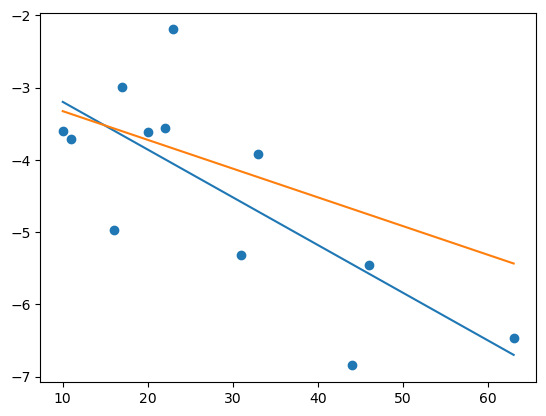

In [122]:
plt.plot(x_arr, y_fit)
plt.plot(x_arr, y_fitw)
plt.scatter(total_cost_glucose, log_leakage)

# Plot

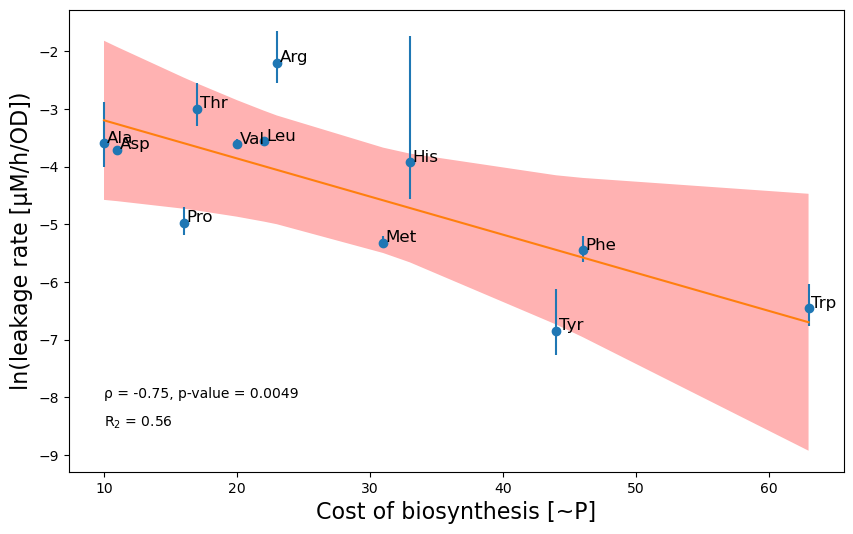

In [160]:
import scipy.stats as st
fig, ax = plt.subplots(1, figsize = (10,6))
label_fontsize = 16
error_min = log_leakage - np.log(leakage-leakage_error)
error_max = np.log(leakage+leakage_error)-log_leakage

#print([(aa, x,y,z) for aa,x,y,z in zip(aa_list, error_max, log_leakage, error_min)])
#ax.scatter(total_cost_glucose, leakage, )
#ax.errorbar(y = log10_leakage, x = total_cost_glucose, yerr = [error_max, error_min], fmt='o')
ax.errorbar(y = log_leakage, x = total_cost_glucose, yerr = [error_max, error_min], fmt='o')
ax.set_ylabel(r"ln(leakage rate [μM/h/OD])", fontdict={"size": label_fontsize})
ax.set_xlabel("Cost of biosynthesis [~P]", fontdict={"size": label_fontsize})
for i, aa in enumerate(aa_list):
    ax.annotate(aa, (total_cost_glucose[i]+0.2, log_leakage[i]+0.01), size = 12)
ax.annotate('ρ = {0:.2f}, p-value = {1:.4f}'.format(rho, pval), (10, -8))
ax.annotate(r'R$_2$ = {0:.2f}'.format(res.rsquared), (10, -8.5))

ax.plot(x_arr, y_fit)


x = np.array(total_cost_glucose)
x.sort()
y = log_leakage
n = len(log_leakage)
yfit = fun(x, *popt)
resid = y - yfit
s_err = np.sqrt(np.sum(resid**2)/(n - 2))
t = st.t.ppf(0.975, n - 2)
ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
plt.fill_between(x, yfit+ci, yfit-ci, color='r', alpha = 0.3, edgecolor='none')
#ax.plot(x_arr, y_fitw)
plt.savefig('cost of biosynthesis vs leakage rate.s

array([0.97032089, 0.93955569, 0.97032089, 0.66299605, 0.67677949,
       0.64241971, 0.79958741, 0.66299605, 0.77506633, 0.71065931,
       1.56656133, 0.90959593])

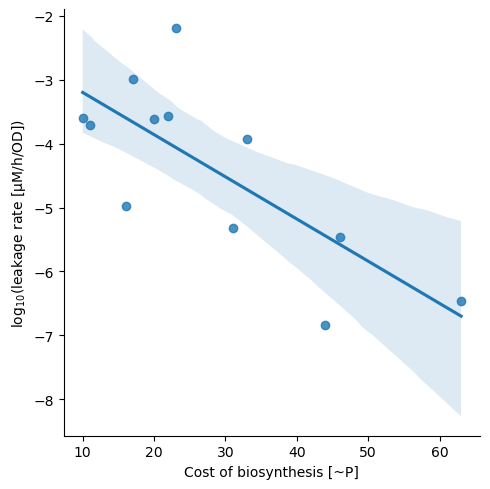

In [134]:
fig, ax
data = pd.DataFrame({'Cost of biosynthesis [~P]':total_cost_glucose, r"log$_{10}$(leakage rate [μM/h/OD])": log_leakage})  
fig = sns.lmplot(data = data, x = 'Cost of biosynthesis [~P]', y = r"log$_{10}$(leakage rate [μM/h/OD])")
#plt.yscale('log')


In [146]:
def linearfit(x, y, yerr):
    """Linear fit of x and y with uncertainty and plots results."""
    
    import numpy as np
    import scipy.stats as stats
    
    x, y = np.asarray(x), np.asarray(y)
    n = y.size
    p, cov = np.polyfit(x, y, 1, w=1/yerr, cov=True)  # coefficients and covariance matrix
    yfit = np.polyval(p, x)                           # evaluate the polynomial at x
    perr = np.sqrt(np.diag(cov))     # standard-deviation estimates for each coefficient
    R2 = np.corrcoef(x, y)[0, 1]**2  # coefficient of determination between x and y
    resid = y - yfit
    chi2red = np.sum((resid/yerr)**2)/(n - 2)  # Chi-square reduced
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.975, n - 2)
    ci = t * s_err * np.sqrt(    1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.fill_between(x, yfit+pi, yfit-pi, color='r', alpha = 0.1, edgecolor='none')
    plt.fill_between(x, yfit+ci, yfit-ci, color='r', alpha = 0.4, edgecolor='none')
    plt.errorbar(x, y, yerr=yerr, fmt = 'bo', ecolor='b', capsize=0)
    plt.plot(x, yfit, 'r', linewidth=3, color=[1, 0, 0, .8])
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.title('$y = %.2f \pm %.2f + (%.2f \pm %.2f)x \; [R^2=%.2f,\, \chi^2_{red}=%.1f]$'
              %(p[1], perr[1], p[0], perr[0], R2, chi2red), fontsize=20, color=[0, 0, 0])  
#    plt.xlim((0, 70))
    plt.show()

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_10333/1446067110.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, yfit, 'r', linewidth=3, color=[1, 0, 0, .8])


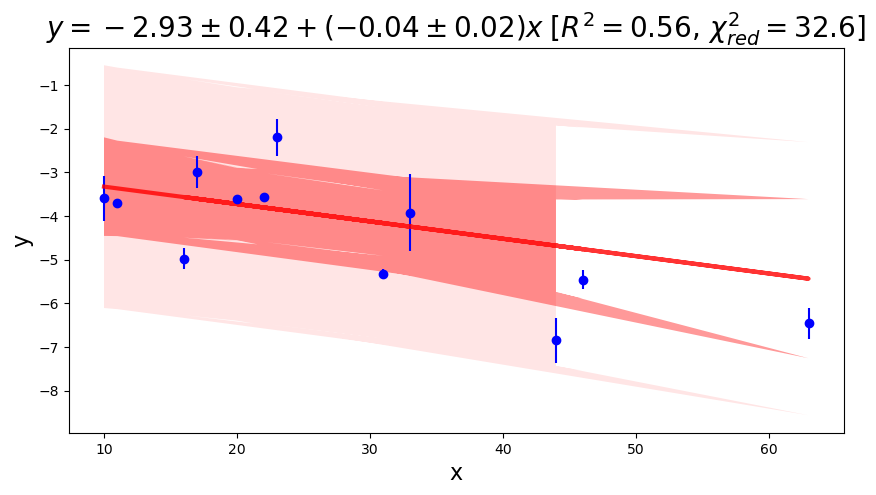

In [147]:
linearfit(total_cost_glucose, log_leakage, log_leakage_error)

In [12]:
error_max

array([0.17936263, 0.02025227, 0.08696694, 0.40253091, 0.27577059,
       0.01252016, 0.04416569, 0.09301648, 0.15339882, 0.13288411,
       0.03763654, 0.12911735, 0.18118325])

In [90]:
st.pearsonr(np.log(leakage), total_cost_glucose)

(-0.7083211449667639, 0.0067345393436468075)

In [71]:
df_cost

Unnamed: 1_level_0       Unnamed: 2_level_0 Glucose                \
Amino acid   One-lettersymbol    Precursor metabolites      ~P   H Total, ~P   
Ala                         A                      pyr       0   5      10.0   
Cys                         C                      3pg       7   8      23.0   
Asp                         D                      oaa       1   5      11.0   
Glu                         E                      αkg       1   5      11.0   
Phe                         F              2 pep, eryP      10  18      46.0   
Gly                         G                      3pg       2   4      10.0   
His                         H                     penP      15   9      33.0   
Ile                         I                 pyr, oaa       3  13      29.0   
Lys                         K                 oaa, pyr       3  12      27.0   
Leu                         L             2 pyr, acCoA       0  11      22.0   
Met                         M           oaa, Cys, -pyr       9  11      31.0   
Asn                         N                      oaa       3   5      13.0   
Pro                         P                      αkg       2   7      16.0   
Gln                         Q                      αkg       2   5      12.0   
Arg                         R                      αkg       9   7      23.0   
Ser                         S                      3pg       2   4      10.0   
Thr                         T                      oaa       3   7      17.0   
Val                         V                    2 pyr       0  10      20.0   
Trp                         W  2 pep, eryP, PRPP, -pyr      19  22      63.0   
Tyr                         Y              eryP, 2 pep      10  17      44.0   

           Acetate               Malate                    Mean  
Amino acid      ~P   H Total, ~P     ~P   H Total, ~P Total, ~P  
Ala              2   6      14.0      1   5      11.0     11.67  
Cys              8   9      26.0      7   9      25.0     24.67  
Asp              2   6      14.0      1   6      13.0     12.67  
Glu              5   8      21.0      2   6      14.0     15.33  
Phe             18  20      58.0     12  20      52.0     52.00  
Gly              3   5      13.0      2   5      12.0     11.67  
His             27   9      45.0     19   9      37.0     38.33  
Ile              6  15      36.0      4  14      32.0     32.33  
Lys              6  14      34.0      4  13      30.0     30.33  
Leu              5  15      35.0      3  11      25.0     27.33  
Met             11  13      37.0      9  13      35.0     34.33  
Asn              4   6      16.0      3   6      15.0     14.67  
Pro              6  10      26.0      3   8      19.0     20.33  
Gln              6   8      22.0      3   6      15.0     16.33  
Arg             13  10      33.0     10   8      26.0     27.33  
Ser              3   5      13.0      2   5      12.0     11.67  
Thr              4   8      20.0      3   8      19.0     18.67  
Val              4  12      28.0      2  10      22.0     23.33  
Trp             39  24      87.0     25  24      73.0     74.33  
Tyr             18  19      56.0     12  19      50.0     50.00

In [70]:
for aa, row in df_cost.iterrows()

SyntaxError: invalid syntax (1235550426.py, line 1)

In [19]:
df_exometabolites

,G6P,F6P,FBP,DHAP,GA3P,23PG,PEP,R5P,RU5P+X5P,E4P,...,LEU,TRP,HIS,ARG,PYR,ORO,FUM,URA,AKG,ACT
Time,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.101467,0.446667,0.000000,0.190667,0.024512,0.054400,0.000000,0.003685,0.000000,0.000000,...,0.041667,0.031867,4.690000,0.138467,0.00,8.00,13.50,88.50,0.0,444.00
2,0.277733,0.782667,0.000000,0.533333,0.009140,0.096667,0.000000,0.017333,0.000000,0.000000,...,0.039967,0.035833,3.856667,0.619000,36.75,15.25,1.25,4.25,0.0,415.00
3,0.362400,0.693333,0.000000,0.828000,0.038120,0.084267,0.000000,0.077600,0.000000,0.000000,...,0.067167,0.042067,3.950000,1.556667,31.75,16.25,1.25,30.75,0.0,328.25
4,0.704000,0.957333,0.000000,1.770667,0.064667,0.093333,0.063280,0.155067,0.052933,0.000000,...,0.105600,0.052033,4.856667,2.943333,34.75,10.25,0.00,46.25,0.0,243.50
5,1.450667,2.194667,0.000000,3.138667,0.197600,0.442667,0.189867,0.302667,0.136533,0.000000,...,0.156000,0.068833,5.670000,4.753333,492.25,147.75,1.00,7.25,0.0,2931.50
6,2.996000,5.760000,0.000000,6.733333,0.666667,1.397333,0.596000,0.881333,0.409467,0.000000,...,0.231333,0.084900,6.493333,6.923333,1686.50,434.00,2.00,48.50,0.0,7585.00
7,6.520000,9.453333,0.000000,11.173333,1.513333,3.140000,1.098667,1.832000,0.744000,0.121333,...,0.347667,0.098767,6.833333,9.613333,2636.00,583.00,2.50,18.50,0.0,8945.50
8,10.720000,18.346667,6.293333,17.733333,3.941333,5.866667,1.820000,2.498667,1.136000,0.400400,...,0.727667,0.112333,6.840000,8.873333,4924.00,998.00,5.00,30.00,5.5,12948.50
